Create statistics of the graphis

In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
import obonet
import networkx as nx

# Load HPO .obo file
url = 'http://purl.obolibrary.org/obo/hp.obo'
graph = obonet.read_obo(url)

# Get root node (Phenotypic abnormality)
root = 'HP:0000118'

# Compute all shortest paths from root to other nodes
depths = {}

for node in graph.nodes:
    try:
        # Longest shortest path from root to node
        all_paths = list(nx.all_simple_paths(graph, source=node, target=root))
        max_depth = max(len(p) - 1 for p in all_paths)
        depths[node] = max_depth
    except:
        # No path from root (e.g., obsolete or orphaned terms)
        depths[node] = None


In [3]:
def get_clinical_note_lengths(df):
    print(f"Mean number of words: {np.mean(df.clinical_note.apply(len))}")
    print(f"""Mean number of characters: {np.mean(df.clinical_note.apply(lambda x: len(x.split(" "))))}""")

- Número de códigos HPO por nota clínica
- Número de códigos HPO únicos
- Depth de códigos HPO
- Distribución por categoría de códigos HPO

In [4]:
def get_code_data(df, class_map):
    print(f"Avg HPO codes per text: {np.mean([len(code_list) for code_list in df.annotations])}")
    unique_codes = [code.replace('_', ':') for code_list in df.annotations for code in code_list]
    unique_codes = set([code for code in unique_codes if code in depths])
    print(f"Unique valid HPO codes in dataset: {len(unique_codes)}, coverage: {len(unique_codes)/19077}")
    code_depths = [depths[code] for code in unique_codes]
    class_counts = [class_map[code] for code in unique_codes]
    return code_depths,  class_counts

In [5]:
df = pd.read_csv('../../datasets/RAG-HPO/Test_Cases.csv')
df["annotations"] = df.annotations.apply(eval)
df = df.rename(columns={'esp':'clinical_note'})
input_keys = ['clinical_note']
output_keys = ['annotations'] 

In [3]:
DATASET_DIR=os.path.join(os.environ['PROJECT_DIR'],"datasets/GSC+")
texts = []
annotations = []
for file in os.listdir(DATASET_DIR + "_ESP/Text"):
    with open(os.path.join(DATASET_DIR + "_ESP/Text", file), "r") as fp:
        texts.append(fp.read())
    annots = pd.read_csv(os.path.join(DATASET_DIR + "/Annotations", file), header=None, sep="\t")
    annots[1] = annots[1].apply(lambda x: x.split("|")[0].strip())
    annotations.append(annots[1].to_list())
gcs_esp = pd.DataFrame({"esp":texts, "annotations":annotations})
gcs_esp.rename(columns={"esp":"clinical_note"}, inplace=True)

In [7]:
get_clinical_note_lengths(df)
get_clinical_note_lengths(gcs_esp)

Mean number of words: 2037.3478260869565
Mean number of characters: 310.5304347826087
Mean number of words: 1106.890350877193
Mean number of characters: 168.10526315789474


In [16]:
df_depths, class_counts_df = get_code_data(df, hpo_to_system)
gsc_depths, class_counts_gsc = get_code_data(gcs_esp, hpo_to_system)

Avg HPO codes per text: 15.68695652173913
Unique valid HPO codes in dataset: 1219, coverage: 0.06389893589138754
Avg HPO codes per text: 12.162280701754385
Unique valid HPO codes in dataset: 436, coverage: 0.022854746553441316


In [17]:
pd.DataFrame(gsc_depths).to_excel("GSC_DEPTHS.xlsx")

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
depths = pd.concat([pd.DataFrame(df_depths), pd.DataFrame(gsc_depths)])
depths["dataset"] = len(df_depths) * ["RAG-HPO"] + len(gsc_depths) * ["GSC"]
depths.rename(columns={0:"depth"}, inplace=True)
depths.reset_index(inplace=True)
# depths = depths.groupby("dataset")["depth"].value_counts().to_frame(name="depth_count").reset_index()

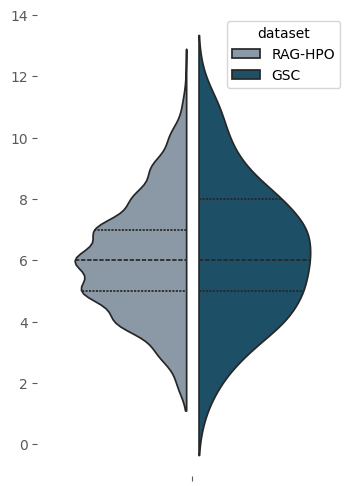

In [49]:
# Create a violin plot
plt.figure(figsize=(4, 6))
sns.violinplot(y="depth", data=depths, hue="dataset", split=True, gap=.1,
                inner="quart", palette=["#8599AA", "#115472"])
# Remove spines and grid
sns.despine(left=True, bottom=True)
plt.tick_params(colors="#595959")
plt.ylabel('')
plt.savefig("violinplot.png")

In [15]:
pd.concat([pd.DataFrame(class_counts_df).value_counts(), pd.DataFrame(class_counts_gsc).value_counts()], axis=1).fillna(0).to_excel("classes_count.xlsx")

NameError: name 'class_counts_df' is not defined

In [14]:
class_df = pd.DataFrame({"hpo_class":class_counts_df + class_counts_gsc,
                        "dataset":len(class_counts_df) * ["RAG-HPO"] + len(class_counts_gsc) * ["GSC+"]})
class_df = class_df.groupby("dataset").hpo_class.value_counts().to_frame()
class_df.to_excel("classes_count.xlsx")

NameError: name 'class_counts_df' is not defined

In [10]:
import json
RESOURCES_DIR= os.path.join(os.environ["PROJECT_DIR"], "./resources")
with open(os.path.join(RESOURCES_DIR, "hpo_es.json"), "r") as fp:
    hpo = json.load(fp)

In [11]:
#Read the desired fields of the ontology
fields = ["esp_name", "esp_def", 'esp_synonyms', "is_a", "name"]
hpo_dict = {}

for element in hpo:
    hpo_dict[element["id"]] = {field:element[field] for field in fields if field in element}

In [15]:
major_systems = {code:hpo_dict[code]["name"] for code in list(graph.predecessors("HP:0000001"))}

In [17]:
# Función para encontrar el primer sistema ancestro
def get_clinical_system(hpo_code):
    # try:
    # Caminos hacia la raíz
    ancestors = list(nx.predecessor(graph, hpo_code).keys())
    for code in major_systems:
        if code in ancestors:
            return major_systems[code]
    return 'Otro'
    # except Exception:
    #     return 'Desconocido'

# Mapeo de cada término HPO a su sistema
hpo_to_system = {}
for node in graph.nodes:
    if node.startswith("HP:"):
        system = get_clinical_system(node)
        hpo_to_system[node] = system

In [26]:
system_count = {}
unique_hpo_codes = set(gcs_esp.annotations.explode())
for code in unique_hpo_codes:
    try:
        system = hpo_to_system[code.replace("_", ":")]
        system_count[system] = system_count.get(system, 0) + 1
    except KeyError:
        continue

In [47]:
hpo_codes = [
    "HP:0000708",
    "HP:0000713",
    "HP:0000733",
    "HP:0000739",
    "HP:0001249",
    "HP:0034004",
    "HP:5200320",
    "HP:5200402"
    ]

for code in hpo_codes:
    print( code, hpo_dict[code]["esp_name"])

HP:0000708 Alteración comportamental
HP:0000713 Agitación
HP:0000733 Comportamiento estereottipado
HP:0000739 Ansiedad
HP:0001249 Discapacidad intelectual
HP:0034004 Parosmia
HP:5200320 Disminución de la búsqueda de relaciones
HP:5200402 Ideas sobrevaloradas


In [35]:
hpo_dict["HP:0001328"]

{'esp_name': 'Discapacidad de aprendizaje específica',
 'esp_def': 'Deterioro de ciertas habilidades, como la lectura o la escritura, la coordinación, el autocontrol o la atención, que interfiere en la capacidad de aprendizaje. La deficiencia no está relacionada con un déficit global de inteligencia.',
 'is_a': 'HP:0012759 ! Neurodevelopmental abnormality',
 'name': 'Specific learning disability'}

In [27]:
system_count

{'Phenotypic abnormality': 419,
 'Mode of inheritance': 8,
 'Clinical modifier': 9}